In [2]:
!pip install kaggle

!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.11G/2.13G [00:24<00:00, 152MB/s]
100% 2.13G/2.13G [00:24<00:00, 92.6MB/s]


In [4]:
!unzip /content/leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [5]:
import numpy as np
import pandas as pd
import os
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt

In [6]:
dir = '/content/leapGestRecog'

In [7]:
images = []
labels = []
for directory in os.listdir(dir):
  for subDir in os.listdir(os.path.join(dir,directory)):
    for img in os.listdir(os.path.join(dir, directory, subDir)):
      img_path = os.path.join(dir, directory, subDir, img)
      images.append(img_path)
      labels.append(subDir)

In [8]:
Iseries = pd.Series(images, name="Images")
Lseries = pd.Series(labels, name="labels")
hand_gesture_data = pd.concat([Iseries, Lseries], axis=1)
hand_gesture_df = pd.DataFrame(hand_gesture_data)

In [9]:
print(hand_gesture_df.head())

                                              Images labels
0  /content/leapGestRecog/07/02_l/frame_07_02_006...   02_l
1  /content/leapGestRecog/07/02_l/frame_07_02_014...   02_l
2  /content/leapGestRecog/07/02_l/frame_07_02_018...   02_l
3  /content/leapGestRecog/07/02_l/frame_07_02_008...   02_l
4  /content/leapGestRecog/07/02_l/frame_07_02_018...   02_l


In [10]:
# counting images in each class
pd.Series(labels).value_counts()

02_l             2000
10_down          2000
08_palm_moved    2000
03_fist          2000
01_palm          2000
05_thumb         2000
04_fist_moved    2000
07_ok            2000
09_c             2000
06_index         2000
Name: count, dtype: int64

In [11]:
X_train, X_test = train_test_split(hand_gesture_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(hand_gesture_df, test_size=0.3, random_state=42)

In [12]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="Images",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= X_test,x_col="Images", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="Images", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )


Found 14000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [13]:
classes=list(train.class_indices.keys())
print (classes)

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [14]:
def show_hand_gesture(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

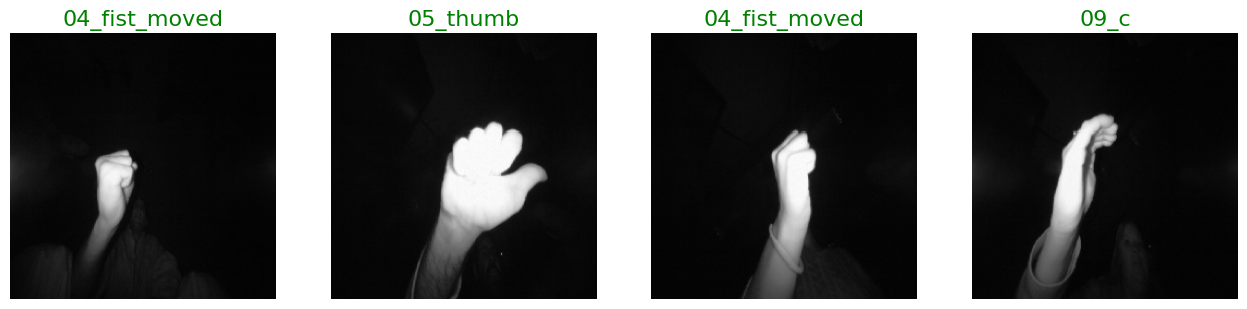

In [15]:
show_hand_gesture(train)

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

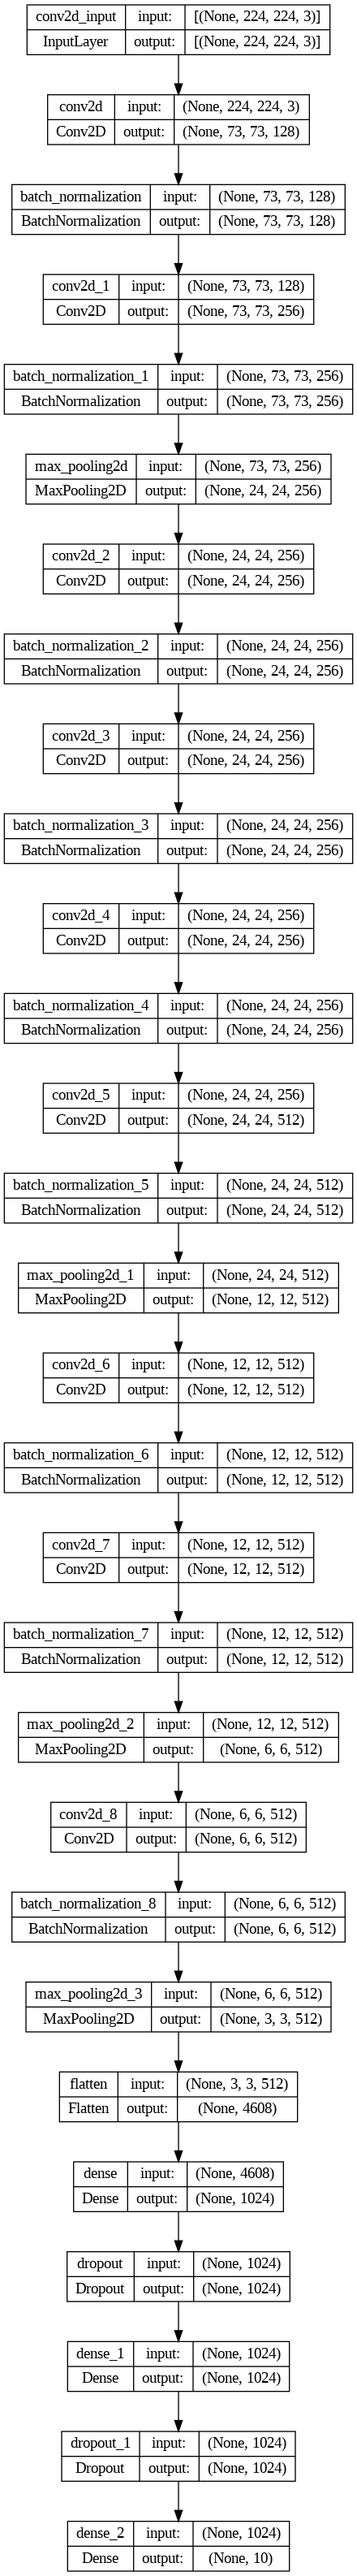

In [17]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
history = model.fit(train, epochs=3, validation_data=val, verbose=1)

Epoch 1/3
3500/3500 [==============================] - 208s 56ms/step - loss: 0.5299 - accuracy: 0.8396 - val_loss: 0.0073 - val_accuracy: 0.9992
Epoch 2/3
3500/3500 [==============================] - 197s 56ms/step - loss: 0.0267 - accuracy: 0.9929 - val_loss: 0.0017 - val_accuracy: 0.9993
Epoch 3/3
3500/3500 [==============================] - 197s 56ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 9.3857e-04 - val_accuracy: 0.9998


In [19]:
model.evaluate(test, verbose=1)

1000/1000 [==============================] - 21s 21ms/step - loss: 4.1278e-04 - accuracy: 1.0000


[0.00041278041317127645, 1.0]

In [20]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

1000/1000 [==============================] - 19s 18ms/step


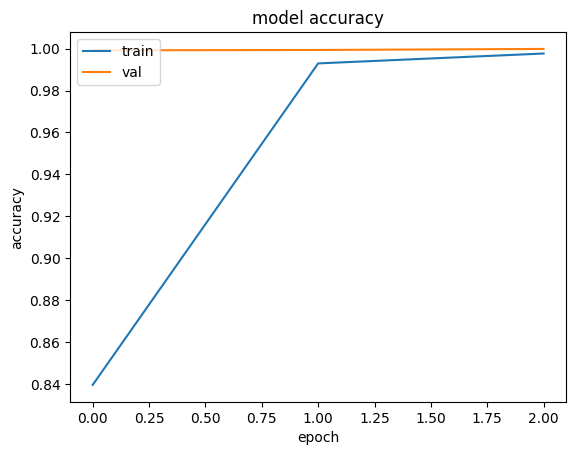

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

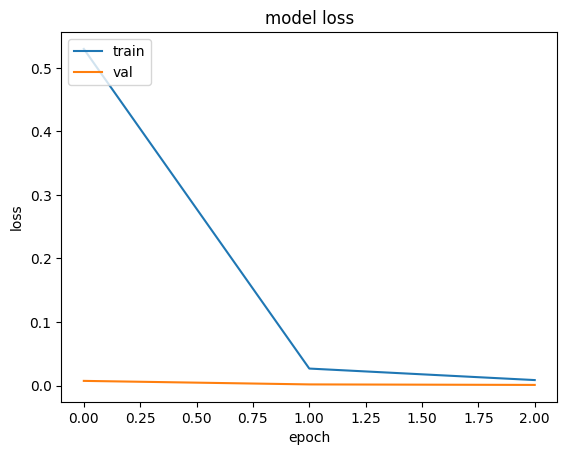

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_test = X_test.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       377
         02_l       1.00      1.00      1.00       417
      03_fist       1.00      1.00      1.00       418
04_fist_moved       1.00      1.00      1.00       403
     05_thumb       1.00      1.00      1.00       392
     06_index       1.00      1.00      1.00       366
        07_ok       1.00      1.00      1.00       409
08_palm_moved       1.00      1.00      1.00       404
         09_c       1.00      1.00      1.00       410
      10_down       1.00      1.00      1.00       404

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000

Accuracy of the Model: 100.0%


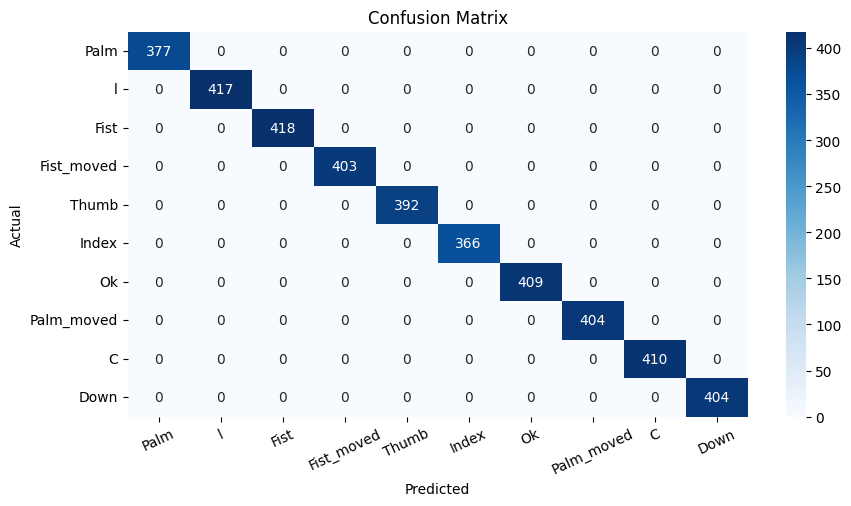

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Palm', 'l', 'Fist', 'Fist_moved', 'Thumb', 'Index', 'Ok', 'Palm_moved', 'C', 'Down']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=25)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()